In [1]:
import toml
with open('config_paths.toml',mode='r') as f:
    paths = toml.load(f, _dict=dict)

In [ ]:
import cplAE_TE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from copy import deepcopy
from pathlib import Path
from tqdm import tqdm

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

from cplAE_TE.utils.tree_helpers import get_merged_ordered_classes

**QDA with coupled autoencoder representations**

In [6]:
representation_path = '/home/rohan/Remote-AI/dat/result/TE_CS/'
origdata_fname = './refactor/data/proc/PS_v5_beta_0-4_pc_scaled_ipfx_eqTE.mat'
htree_fname='./refactor/data/proc/dend_RData_Tree_20181220.csv'
O = sio.loadmat(origdata_fname,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds=20
latent_dim=3
aug = 1
modeltype = 'best_loss' #['best_loss','exit_500_ft','exit']

In [7]:
#Load all CV sets
CVdict={}
key_list = ['zE','zT','train_ind','val_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname=(f'CS_Edat_pcipfx_aT_{alpha_T:0.1f}_aE_{alpha_E:0.1f}_cs_{lambda_TE:0.1f}'+\
                  f'_ad_{aug:d}_ld_3_bs_200_se_500_ne_1500_cv_{cv:d}_ri_0_{modeltype}-summary').replace('.','-') + '.mat'
    
    if Path(representation_path+cvfold_fname).is_file(): 
        X = sio.loadmat(representation_path+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 20/20 [00:04<00:00,  4.36it/s]


In [ ]:
ttypes,counts = np.unique(O['cluster'],return_counts=True)
for x in zip(ttypes,counts): print(x)

In [18]:
n_min_training_samples = 6
dummy_most_freq = DummyClassifier(strategy="most_frequent")
dummy_prior = DummyClassifier(strategy="stratified")

fiton = 'zE'

for cv in tqdm(CVdict.keys()):
    D = CVdict[cv]
    CVdict[cv]['qda'] = {}
    CVdict[cv]['qda']['n_components'] = []
    CVdict[cv]['qda']['n_htree_classes'] = []
    CVdict[cv]['qda']['acc_train'] = []
    CVdict[cv]['qda']['acc_val'] = []
    CVdict[cv]['qda']['acc_test'] = []
    CVdict[cv]['qda']['acc_most_freq'] = []
    CVdict[cv]['qda']['acc_prior'] = []
    
    for n_classes in [59]:#np.arange(5,61,5):
        
        merged_labels, _ = get_merged_ordered_classes(data_labels=deepcopy(O['cluster']),
                                                      htree_file=htree_fname,
                                                      n_required_classes=n_classes,verbose=False)
        
        X_train = deepcopy(D[fiton][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D[fiton][D['val_ind']])
        y_val   = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_training_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_training_samples)]
        #print(df_train_del['lbl'].value_counts())
        
        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #QDA related metrics
        n_lbls = np.size(np.unique(y_train))
        qda = QDA(reg_param=1e-2,store_covariance=True)
        qda.fit(X_train,y_train)
        y_train_pred = qda.predict(X_train)
        y_val_pred = qda.predict(X_val)
        CVdict[cv]['qda']['n_htree_classes'].append(n_classes)
        CVdict[cv]['qda']['n_components'].append(np.unique(qda.classes_).size)
        CVdict[cv]['qda']['acc_train'].append(accuracy_score(y_train, y_train_pred))
        CVdict[cv]['qda']['acc_val'].append(accuracy_score(y_val, y_val_pred))
            
        #For dummy classifiers
        dummy_most_freq.fit(D[fiton],merged_labels)
        most_freq_pred=dummy_most_freq.predict(D[fiton])
        dummy_prior.fit(D[fiton],merged_labels)
        prior_pred=dummy_prior.predict(D[fiton])
        CVdict[cv]['qda']['acc_most_freq'].append(accuracy_score(merged_labels, most_freq_pred))
        CVdict[cv]['qda']['acc_prior'].append(accuracy_score(merged_labels, prior_pred))

100%|██████████| 20/20 [00:01<00:00, 13.12it/s]


In [19]:
train_acc = []
val_acc = []
n_components = []
dummy_prior_acc=[]
dummy_most_freq_acc=[]
for cv in CVdict.keys():
    train_acc.extend(CVdict[cv]['qda']['acc_train'])
    val_acc.extend(CVdict[cv]['qda']['acc_val'])
    n_components.extend(CVdict[cv]['qda']['n_components'])
    
    #For dummy classifiers
    dummy_most_freq_acc.extend(CVdict[cv]['qda']['acc_most_freq'])
    dummy_prior_acc.extend(CVdict[cv]['qda']['acc_prior'])

In [20]:
dummy_prior_acc = np.array(dummy_prior_acc)
n_components = np.array(n_components)
n_classes = 54
print(f'{np.mean(dummy_prior_acc[n_components==n_classes]):0.3f} accuracy for {n_classes} classes with dummy classifier')

0.033 accuracy for 54 classes with dummy classifier


Text(0, 0.5, 'Accuracy')

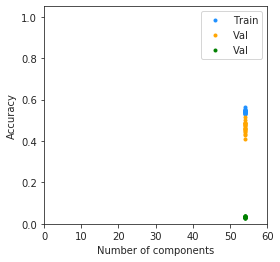

In [21]:
#Visual check before saving results:
plt.figure(figsize=(4,4))
plt.plot(n_components,train_acc,'.',color='dodgerblue',label='Train')
plt.plot(n_components,val_acc,'.',color='orange',label='Val')
plt.plot(n_components,dummy_prior_acc,'.',color='green',label='Val')
plt.legend()
ax = plt.gca()
ax.set_ylim(0,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

In [12]:
res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
df=pd.DataFrame({'n_components':n_components,'test_acc':test_acc,'val_acc':val_acc,'train_acc':train_acc})

fname = 'QDA_'+fiton+'_CS'+\
                '_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_3_bs_200_se_500_ne_1500'
fname = fname.replace('.','-')+'.csv'
df.to_csv(res_pth+fname)

**QDA with PC-CCA baselines**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm

sns.set()
sns.set_style('ticks',{'axes.grid' : False})
%matplotlib inline

In [ ]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds=44
latent_dim=10
aug = 1

#Load all CV sets
#with timebudget('load all cv sets'):
CVdict={}
key_list = ['zE','zT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_'+str(latent_dim)+\
                '_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                '_ri_0-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if isfile(representation_pth+cvfold_fname): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

In [28]:
n_min_samples = 6

n_pc_T = 50
n_pc_E = 50
cca_dims = 10
fiton = 'zE'
cca = CCA(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)

In [29]:
for cv in tqdm(CVdict.keys()):
    D = deepcopy(CVdict[cv])
    CVdict[cv]['pc_cca_qda'] = {}
    CVdict[cv]['pc_cca_qda']['n_components'] = []
    CVdict[cv]['pc_cca_qda']['n_htree_classes'] = []
    CVdict[cv]['pc_cca_qda']['acc_train'] = []
    CVdict[cv]['pc_cca_qda']['acc_val'] = []
    CVdict[cv]['pc_cca_qda']['acc_test'] = []
    
    XT = deepcopy(O['T_dat'])
    XE = deepcopy(np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1))
    XE[np.isnan(XE)]=0.0
    train_ind = D['train_ind']
    
    #Reduce dims of T data
    if n_pc_T is not None:
        pca = PCA(n_components=n_pc_T)
        pca.fit_transform(XT[train_ind,:])
        XT = pca.transform(XT)
  
    #Reduce dims of E data
    if n_pc_E is not None:
        pca = PCA(n_components=n_pc_E)
        pca.fit_transform(XE[train_ind,:])
        XE = pca.transform(XE)

    #CCA on T and E data
    cca.fit(XT[train_ind,:],XE[train_ind,:])
    D['zT'],D['zE'] = cca.transform(XT,XE)
    
    D['zT'] = D['zT'] - np.mean(D['zT'], axis=0)
    D['zT'] = np.matmul(D['zT'], sqrtm(np.linalg.inv(np.cov(np.transpose(D['zT'])))))
    
    D['zE'] = D['zE'] - np.mean(D['zE'], axis=0)
    D['zE'] = np.matmul(D['zE'], sqrtm(np.linalg.inv(np.cov(np.transpose(D['zE'])))))

    for n_classes in np.arange(5,61,5):

        merged_labels, _ = get_merged_ordered_classes(data_labels=deepcopy(O['cluster']),
                                                      htree_file=htree_file,
                                                      n_required_classes=n_classes)
        
        X_train = deepcopy(D[fiton][D['train_ind']])
        y_train = deepcopy(merged_labels[D['train_ind']])
        ind_train = np.arange(0,np.shape(X_train)[0])

        X_val   = deepcopy(D[fiton][D['val_ind']])
        y_val = deepcopy(merged_labels[D['val_ind']])
        ind_val = np.arange(0,np.shape(X_val)[0])

        X_test   = deepcopy(D[fiton][D['test_ind']])
        y_test = deepcopy(merged_labels[D['test_ind']])
        ind_test = np.arange(0,np.shape(X_test)[0])

        #Remove types with low sample counts in training set
        df = pd.DataFrame({'ind':ind_train,'lbl':y_train})
        df_train = df[df.groupby('lbl')['lbl'].transform('count').ge(n_min_samples)]
        keep_ind = df_train['ind'].values
        X_train = X_train[keep_ind,:]
        y_train = y_train[keep_ind]

        #Print types that were removed
        #df_train_del = df[df.groupby('lbl')['lbl'].transform('count').lt(n_min_samples)]
        #print(df_train_del['lbl'].value_counts())

        #Remove types from validation set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_val,'lbl':y_val})
        df_val = df[df['lbl'].isin(y_train)]
        keep_ind = df_val['ind'].values
        X_val = X_val[keep_ind,:]
        y_val = y_val[keep_ind]

        #Remove types from test set that are not represented in the training set
        df = pd.DataFrame({'ind':ind_test,'lbl':y_test})
        df_test = df[df['lbl'].isin(y_test)]
        keep_ind = df_test['ind'].values
        X_test = X_test[keep_ind,:]
        y_test = y_test[keep_ind]

        #QDA related metrics
        qda = QDA(reg_param=1e-2,store_covariance=True)
        qda.fit(X_train,y_train)
        y_train_pred = qda.predict(X_train)
        y_val_pred = qda.predict(X_val)
        y_test_pred = qda.predict(X_test)
        CVdict[cv]['pc_cca_qda']['n_htree_classes'].append(n_classes)
        CVdict[cv]['pc_cca_qda']['n_components'].append(np.unique(qda.classes_).size)
        CVdict[cv]['pc_cca_qda']['acc_train'].append(accuracy_score(y_train, y_train_pred))
        CVdict[cv]['pc_cca_qda']['acc_val'].append(accuracy_score(y_val, y_val_pred))
        CVdict[cv]['pc_cca_qda']['acc_test'].append(accuracy_score(y_test, y_test_pred))

100%|██████████| 44/44 [02:14<00:00,  3.05s/it]


In [30]:
test_acc = []
val_acc = []
train_acc = []
n_components = []
for cv in CVdict.keys():
    test_acc.extend(CVdict[cv]['pc_cca_qda']['acc_test'])
    val_acc.extend(CVdict[cv]['pc_cca_qda']['acc_val'])
    train_acc.extend(CVdict[cv]['pc_cca_qda']['acc_train'])
    n_components.extend(CVdict[cv]['pc_cca_qda']['n_components'])

Text(0, 0.5, 'Accuracy')

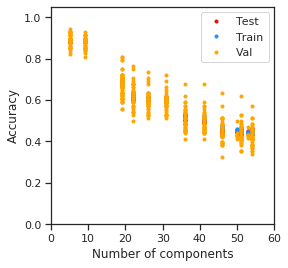

In [31]:
plt.figure(figsize=(4,4))
plt.plot(n_components,test_acc,'.',color='red',label='Test')
plt.plot(n_components,train_acc,'.',color='dodgerblue',label='Train')
plt.plot(n_components,val_acc,'.',color='orange',label='Val')
plt.legend()
ax = plt.gca()
ax.set_ylim(0,1.05)
ax.set_xlim(0,60)
ax.set_xlabel('Number of components')
ax.set_ylabel('Accuracy')

In [32]:
res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
df=pd.DataFrame({'n_components':n_components,'test_acc':test_acc,'val_acc':val_acc,'train_acc':train_acc})

fname = 'QDA_'+fiton+'_PCCCA_'+\
        'CS_Edat_pcipfx_'+str(n_pc_T)+'-'+str(n_pc_E)+'-pc-'+\
        str(cca_dims)+'-cca'
                
fname = fname.replace('.','-')+'.csv'
df.to_csv(res_pth+fname)

**Supervised celltype classification comparisons with linear baselines**

1. QDA parameters should be the same
2. Validation sets for PC-CCA and AE should be the same

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from copy import deepcopy

sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

IndexError: list index out of range

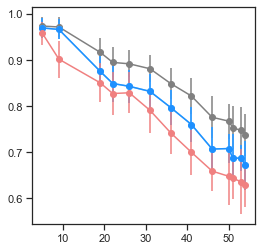

In [3]:
fiton_txt=['z_t','z_e']
for txt_ind,fiton in enumerate(['zT','zE']):
    res_pth = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
    #'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_0-5_ad_0_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
    #'QDA_{:s}_NM_aT_1-0_aE_1-0_cs_1-0_ad_0_ld_3_bs_200_se_500_ne_1500.csv'.format(fiton),\
    fname_list = [f'QDA_{fiton}_NM_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3_bs_200_se_500_ne_1500.csv',\
                  f'QDA_{fiton}_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500.csv',\
                  f'QDA_{fiton}_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500.csv',\
                  f'QDA_{fiton}_NM_aT_1-0_aE_1-0_cs_1-0_ad_0_ld_3_bs_200_se_500_ne_1500.csv',\
                  f'QDA_{fiton}_PCCCA_NM_Edat_pcipfx_10-10-pc-3-cca.csv',\
                  f'QDA_{fiton}_PCCCA_NM_Edat_pcipfx_50-50-pc-3-cca.csv']

    df_list = [pd.read_csv(res_pth+fname) for fname in fname_list]

    plt.figure(figsize=(4,4))
    col = ['gray',\
           'lightskyblue','dodgerblue',\
           'lightcoral','red']
    lbl = [r'$\lambda_{te}$ = 0.0',\
           r'$\lambda_{te}$ = 1.0',\
           'PC-CCA (10,10)',\
           'PC-CCA (50,50)']
    for i,df in enumerate(df_list):
        x_=[]
        y_=[]
        yerr_=[]
        for n in np.unique(df['n_components'].values):
            ind = df['n_components'].values==n
            x_.append(n)
            y_.append(np.mean(df['val_acc'].values[ind]))
            yerr_.append(np.std(df['val_acc'].values[ind]))
        plt.errorbar(x_,y_,yerr_,marker='o',color=col[i],label=lbl[i])

    if fiton=='zT':
        plt.legend()
    ax = plt.gca()
    ax.set_ylim(0.2,1.05)
    ax.set_xlim(0,60)
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Accuracy')
    ax.set_title(r'${:s}$ $\rightarrow$ celltype'.format(fiton_txt[txt_ind]))
    
    plt.tight_layout()
    plt.show()
    #plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/{:s}-to-celltype-20-fold.png'.format(fiton),dpi=300)
    

**Reconstruction comparisons**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
import pdb
from timebudget import timebudget
from copy import deepcopy
from os.path import isfile
from tqdm import tqdm

from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
from sklearn.metrics import r2_score as r2

In [2]:
from refactor.utils.compute import CCA_extended

In [3]:
representation_pth = '/home/rohan/Remote-AI/dat/result/TE_NM/'
origdata_pth = '/home/rohan/Remote-AI/dat/raw/patchseq-v4/PS_v5_beta_0-4_pc_scaled_ipxf_eqTE.mat'
O = sio.loadmat(origdata_pth,squeeze_me=True)

#Representations
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
latent_dim=10
n_cvfolds=44
aug = 1

#Load all CV sets
#with timebudget('load all cv sets'):
CVdict={}
key_list = ['XrT','XrE_from_XT','XrT_from_XE','XrE','zE','zT','train_ind','val_ind','test_ind']
for cv in tqdm(range(n_cvfolds)):
    cvfold_fname='NM_Edat_pcipfx_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_cs_'+str(lambda_TE)+\
                '_ad_'+str(aug)+\
                '_ld_'+str(latent_dim)+\
                '_bs_200_se_500_ne_1500_cv_'+str(cv)+\
                '_ri_0_500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    if isfile(representation_pth+cvfold_fname): 
        X = sio.loadmat(representation_pth+cvfold_fname,squeeze_me=True)
        CVdict[cv] = {key:X[key] for key in key_list}
        del X
    else:
        print(cvfold_fname,'not found')

100%|██████████| 44/44 [00:28<00:00,  1.56it/s]


In [4]:
n_pc_T = 50
n_pc_E = 50
cca_dims = latent_dim

In [5]:
XT_orig = O['T_dat']
XE_orig = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
mask_E = np.ones_like(XE_orig)
mask_E[np.isnan(XE_orig)]=0.0
XE_orig[np.isnan(XE_orig)]=0.0

ind_list = ['train','val','test']

for cv in tqdm(CVdict.keys()):
    cca = CCA_extended(n_components=cca_dims, scale=True, max_iter=1e4, tol=1e-06, copy=True)
    
    CVdict[cv]['ae'] = {}
    CVdict[cv]['cca'] = {}
    
    D = deepcopy(CVdict[cv])
    XT = deepcopy(XT_orig)
    XE = deepcopy(XE_orig)
    train_ind = D['train_ind']

    #Reduce dims of T data
    pcaT = PCA(n_components=n_pc_T)
    pcaT.fit_transform(XT[train_ind,:])
    XTpc = pcaT.transform(XT)

    #Reduce dims of E data
    pcaE = PCA(n_components=n_pc_E)
    pcaE.fit_transform(XE[train_ind,:])
    XEpc = pcaE.transform(XE)

    #CCA on T and E data
    cca.fit(XTpc[train_ind,:],XEpc[train_ind,:])
    XTcca,XEcca = cca.transform(XTpc,XEpc)
        
    #Reconstruction from CCA co-ordinates----------------------------
    #Within modality reconstruction
    XrTpc,XrEpc = cca.inverse_transform_xy(XTcca,XEcca)
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)
    
    T_se = (XT_orig - XrT)**2
    E_se = ((XE_orig - XrE)**2)

    #Within modality reconstruction - MSE and R2 calculations
    for s in ind_list:
        CVdict[cv]['cca']['XT_from_XT_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XE_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XT_from_XT_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],XrT[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XE_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],XrE[D[s+'_ind'],:])
    
    #Cross modality reconstruction
    XrTpc,XrEpc = cca.inverse_transform_xy(XEcca,XTcca) #Input order to inverse_transform_xy is flipped
    XrT = pcaT.inverse_transform(XrTpc)
    XrE = pcaE.inverse_transform(XrEpc)
    
    T_se = (XT_orig - XrT)**2
    E_se = (XE_orig - XrE)**2
    
    for s in ind_list:
        CVdict[cv]['cca']['XT_from_XE_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XT_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['cca']['XT_from_XE_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],XrT[D[s+'_ind'],:])
        CVdict[cv]['cca']['XE_from_XT_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],XrE[D[s+'_ind'],:])
        
        
    #Within Modality AE
    T_se = (XT_orig - D['XrT'])**2
    E_se = (XE_orig - D['XrE'])**2
    for s in ind_list:
        CVdict[cv]['ae']['XT_from_XT_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XE_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XT_from_XT_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],D['XrT'][D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XE_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],D['XrE'][D[s+'_ind'],:])
        
    #Cross modality reconstruction AE
    T_se = (XT_orig - D['XrT_from_XE'])**2
    E_se = (XE_orig - D['XrE_from_XT'])**2
    for s in ind_list:
        CVdict[cv]['ae']['XT_from_XE_'+s] = np.mean(T_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XT_'+s] = np.nanmean(E_se[D[s+'_ind'],:])
        CVdict[cv]['ae']['XT_from_XE_R2_'+s] = r2(XT_orig[D[s+'_ind'],:],D['XrT_from_XE'][D[s+'_ind'],:])
        CVdict[cv]['ae']['XE_from_XT_R2_'+s] = r2(XE_orig[D[s+'_ind'],:],D['XrE_from_XT'][D[s+'_ind'],:])


100%|██████████| 44/44 [01:01<00:00,  1.40s/it]


In [6]:
result_path = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'

L={}
L['cv'] = []
for i,cv in enumerate(CVdict.keys()):
    L['cv'].append(cv)
    for k in CVdict[cv]['cca'].keys():
        if i == 0:
            L[k]=[]
        L[k].append(CVdict[cv]['cca'][k])
        
df_cca = pd.DataFrame(L)
fname = 'Recon_CCA_NM_{:d}-{:d}-pc_{:d}_cca.csv'.format(n_pc_T,n_pc_T,cca_dims)
df_cca.to_csv(result_path+fname)



M={}
M['cv'] = []
for i,cv in enumerate(CVdict.keys()):
    M['cv'].append(cv)
    for k in CVdict[cv]['ae'].keys():
        if i == 0:
            M[k]=[]
        M[k].append(CVdict[cv]['ae'][k])

df_ae = pd.DataFrame(M)
fname = 'Recon_AE_NM_aT_{:.1f}_aE_{:.1f}'\
        '_cs_{:.1f}_ad_{:d}_ld_{:d}'.format(alpha_T,alpha_E,lambda_TE,aug,latent_dim)
fname = fname.replace('.','-')+'.csv'
df_ae.to_csv(result_path+fname)

In [1]:
result_path = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
fname_list = ['Recon_CCA_NM_10-10-pc_3_cca.csv',\
              'Recon_CCA_NM_50-50-pc_3_cca.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_0-5_ad_1_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_0-0_ad_0_ld_3_bs_200_se_500_ne_1500_ft_500.csv'              
              ]
df_list = []

for fname in fname_list:
    #print(fname)
    df_list.append(pd.read_csv(result_path+fname))

In [2]:
#Remove single cross validation fold - something went wrong here.
df_list[3].drop(index=35,inplace=True)

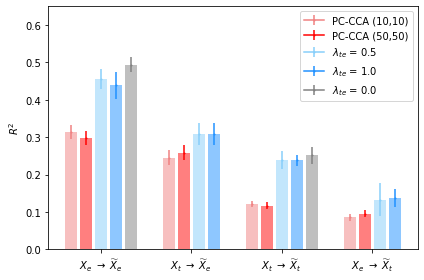

In [3]:
col = ['lightcoral','red',\
       'lightskyblue','dodgerblue',\
       'gray',]

#r'$\lambda_{te}$ = 0.5 (aug)',r'$\lambda_{te}$ = 1.0 (aug)',\
lbl = ['PC-CCA (10,10)','PC-CCA (50,50)',\
       r'$\lambda_{te}$ = 0.5',\
       r'$\lambda_{te}$ = 1.0',\
       r'$\lambda_{te}$ = 0.0'] 
h_list=[]
plt.figure(figsize=(6,4))
for grp,key in enumerate(['XE_from_XE_',
                          'XE_from_XT_',
                          'XT_from_XT_',
                          'XT_from_XE_']):
    meas = 'R2_val'
    key = key+meas
    for i,df in enumerate(df_list):

        if (key in ['XE_from_XT_'+meas,'XT_from_XE_'+meas]):
            if i not in [4]: #Ignore cross modal reconstruction for lambda_TE=0
                plt.bar((i+0.5+(6*grp)),np.mean(df[key].values),color=col[i],alpha=0.5)
                h = plt.errorbar((i+0.5+(6*grp)),np.mean(df[key].values),np.std(df[key].values),marker='o',ms=1,color=col[i],label=lbl[i])
        else:
            plt.bar((i+(6*grp)),np.mean(df[key].values),color=col[i],alpha=0.5)
            h = plt.errorbar((i+(6*grp)),np.mean(df[key].values),np.std(df[key].values),marker='o',ms=1,color=col[i],label=lbl[i])

            if grp==0:
                h_list.append(h) #To get handles for legends
                
plt.legend(handles=h_list,labels=lbl)
ax = plt.gca()
ax.set_ylim(0,0.65)
ax.set_xlabel('')
ax.set_xticks(np.array([2,8,14,20]))
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$',])
ax.set_ylabel(r'$R^2$')
plt.tight_layout()
#plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/Reconstructions'+meas+'.png',dpi=300)
plt.show()

**5 dim results**

In [6]:
#Results also available for ad_0
result_path = '/home/rohan/Remote-AI/dat/result/Patchseq_NM_proc/'
fname_list = ['Recon_CCA_NM_50-50-pc_3_cca.csv',\
              'Recon_CCA_NM_50-50-pc_5_cca.csv',\
              'Recon_CCA_NM_50-50-pc_10_cca.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_0_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_5_bs_200_se_500_ne_1500_ft_500.csv',\
              'Recon_AE_NM_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_10_bs_200_se_500_ne_1500_ft_500.csv',\
              ]
df_list = []

for fname in fname_list:
    #print(fname)
    df_list.append(pd.read_csv(result_path+fname))

In [7]:
#Remove single cross validation fold - something went wrong here.
df_list[3].drop(index=35,inplace=True)

In [ ]:
col = ['lightcoral','tomato','red','grey',
       'lightskyblue','dodgerblue','royalblue']

#r'$\lambda_{te}$ = 0.5 (aug)',r'$\lambda_{te}$ = 1.0 (aug)',\
lbl = ['3 dim PC-CCA (50,50)',\
       '5 dim PC-CCA (50,50)',\
       '10 dim PC-CCA (50,50)',\
       r'3 dim $\lambda_{te}$ = 1.0, no augmentation',\
       r'3 dim $\lambda_{te}$ = 1.0',\
       r'5 dim $\lambda_{te}$ = 1.0',\
       r'10 dim $\lambda_{te}$ = 1.0']
       

h_list=[]
plt.figure(figsize=(6,4))
for grp,key in enumerate(['XE_from_XE_',
                          'XE_from_XT_',
                          'XT_from_XT_',
                          'XT_from_XE_']):
    meas = 'R2_val'
    key = key+meas
    for i,df in enumerate(df_list):
        print(col[i])
        plt.bar((i+(8*grp)),np.mean(df[key].values),color=col[i],alpha=0.5)
        h = plt.errorbar((i+(8*grp)),np.mean(df[key].values),np.std(df[key].values),marker='o',ms=1,color=col[i],label=lbl[i])

        if grp==0:
            h_list.append(h) #To get handles for legends
            #pass
                
plt.legend(handles=h_list,labels=lbl)
ax = plt.gca()
ax.set_ylim(0,0.65)
ax.set_xlabel('')
ax.set_xticks(np.array([0,1,2,3])*8+2.5)
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$',])
ax.set_ylabel(r'$R^2$')
plt.tight_layout()
#plt.savefig('/home/rohan/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_NM_2020/reconstruction_dim_dependence.png',dpi=300)
plt.show()

### Reconstruction error comparisons with CCA, and cplAE with and without augmentation

In [11]:
from sklearn.metrics import r2_score as r2
import seaborn as sns
import scipy.io as sio
from pathlib import Path
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

def calc_r2(XT,XE,CVdict):
    r2_T_from_T=[]
    r2_T_from_E=[]
    r2_E_from_E=[]
    r2_E_from_T=[]
    for cv in CVdict.keys():
        ind = CVdict[cv]['val_ind']
        r2_T_from_T.append(r2(XT[ind,:], CVdict[cv]['XrT'][ind,:]))
        r2_T_from_E.append(r2(XT[ind,:], CVdict[cv]['XrT_from_XE'][ind,:]))
        r2_E_from_E.append(r2(XE[ind,:], CVdict[cv]['XrE'][ind,:]))
        r2_E_from_T.append(r2(XE[ind,:], CVdict[cv]['XrE_from_XT'][ind,:]))

    return [np.mean(x) for x in [r2_E_from_E, r2_E_from_T, r2_T_from_T, r2_T_from_E]],\
           [np.std(x) for x in [r2_E_from_E, r2_E_from_T, r2_T_from_T, r2_T_from_E]],\
           pd.DataFrame({'r2_E_from_E':r2_E_from_E, 'r2_E_from_T':r2_E_from_T, 'r2_T_from_T':r2_T_from_T, 'r2_T_from_E':r2_T_from_E})



representation_path = '/home/rohan/Remote-AI/dat/result/TE_CS/'
origdata_fname = './refactor/data/proc/PS_v5_beta_0-4_pc_scaled_ipfx_eqTE.mat'
htree_fname='./refactor/data/proc/dend_RData_Tree_20181220.csv'
O = sio.loadmat(origdata_fname,squeeze_me=True)
O['E_pcipxf'] = np.concatenate([O['E_pc_scaled'],O['E_feature']],axis = 1)
O['E_pcipxf'][np.isnan(O['E_pcipxf'])]=0
XT = O['T_dat'].copy()
XE = O['E_pcipxf'].copy()
R = {}

In [12]:
#Load cplAE CV sets
alpha_T=1.0
alpha_E=1.0
lambda_TE=1.0
n_cvfolds=20
latent_dim=3

for modeltype in ['best_loss']:
    for aug in [0,1]:
        CVdict={}
        key_list = ['XrT','XrT_from_XE','XrE','XrE_from_XT','zE','zT','train_ind','val_ind']
        for cv in range(n_cvfolds):
            cvfold_fname=(f'CS_Edat_pcipfx_aT_{alpha_T:0.1f}_aE_{alpha_E:0.1f}_cs_{lambda_TE:0.1f}'+\
                          f'_ad_{aug:d}_ld_3_bs_200_se_500_ne_1500_cv_{cv:d}_ri_0_{modeltype}-summary').replace('.','-') + '.mat'

            if Path(representation_path+cvfold_fname).is_file(): 
                X = sio.loadmat(representation_path+cvfold_fname,squeeze_me=True)
                CVdict[cv] = {key:X[key] for key in key_list}
                del X
            else:print(cvfold_fname,'not found')

        [avg,std,df] = calc_r2(XT=XT.copy(),XE=XE.copy(),CVdict=CVdict)
        print(f'aug {aug} {modeltype} cplAE E->E: {avg[0]:0.3f}+{std[0]:0.3f}  T->E: {avg[1]:0.3f}+{std[1]:0.3f}  T->T: {avg[2]:0.3f}+{std[2]:0.3f}  E->T: {avg[3]:0.3f}+{std[3]:0.3f}')
        R[f'ae_{aug}_mean'] = avg
        R[f'ae_{aug}_std'] = std
        R[f'ae_{aug}_df'] = df

aug 0 best_loss cplAE E->E: 0.502+0.016  T->E: 0.215+0.021  T->T: 0.267+0.005  E->T: 0.086+0.009
aug 1 best_loss cplAE E->E: 0.479+0.016  T->E: 0.332+0.020  T->T: 0.260+0.006  E->T: 0.163+0.009


In [13]:
#Load pc-cca CV sets
n_cvfolds=20
cca_dim=3
for pc_dim in [10,20,50]:
    
    CVdict={}
    key_list = ['XrT','XrT_from_XE','XrE','XrE_from_XT','zE','zT','train_ind','val_ind']
    for cv in range(n_cvfolds):
        cvfold_fname=f'PCCCA_Edat_pcipfx_pcT_{pc_dim}_pcE_{pc_dim}_cca_{cca_dim}_cv_{cv}.mat'

        if Path(representation_path+cvfold_fname).is_file(): 
            X = sio.loadmat(representation_path+cvfold_fname,squeeze_me=True)
            CVdict[cv] = {key:X[key] for key in key_list}
            del X
        else: print(cvfold_fname,'not found')

    [avg,std,df] = calc_r2(XT=XT.copy(),XE=XE.copy(),CVdict=CVdict)    
    print(f'{pc_dim}-{cca_dim} pccca E->E: {avg[0]:0.3f}+{std[0]:0.3f}  T->E: {avg[1]:0.3f}+{std[1]:0.3f}  T->T: {avg[2]:0.3f}+{std[2]:0.3f}  E->T: {avg[3]:0.3f}+{std[3]:0.3f}')
    R[f'pc_{pc_dim}_cca_{cca_dim}_mean'] = avg
    R[f'pc_{pc_dim}_cca_{cca_dim}_std'] = std
    R[f'pc_{pc_dim}_cca_{cca_dim}_df'] = df

10-3 pccca E->E: 0.318+0.010  T->E: 0.250+0.014  T->T: 0.136+0.003  E->T: 0.100+0.005
20-3 pccca E->E: 0.309+0.011  T->E: 0.258+0.014  T->T: 0.132+0.003  E->T: 0.105+0.005
50-3 pccca E->E: 0.302+0.011  T->E: 0.262+0.013  T->T: 0.132+0.003  E->T: 0.110+0.004


In [4]:
R.keys()

dict_keys(['ae_0_mean', 'ae_0_std', 'ae_1_mean', 'ae_1_std', 'pc_10_cca_3_mean', 'pc_10_cca_3_std', 'pc_20_cca_3_mean', 'pc_20_cca_3_std', 'pc_50_cca_3_mean', 'pc_50_cca_3_std'])

In [8]:
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42 
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 22})

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline
import matplotlib.lines as mlines

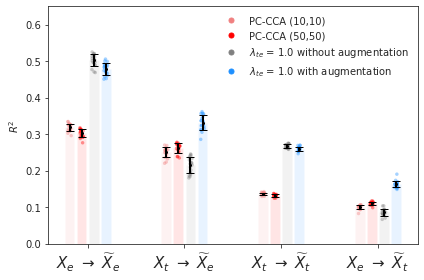

In [21]:
lbl = ['']
col = ['lightcoral',
       'red',\
       'gray',
       'dodgerblue']

#r'$\lambda_{te}$ = 0.5 (aug)',r'$\lambda_{te}$ = 1.0 (aug)',\
lbl = ['PC-CCA (10,10)',
       'PC-CCA (50,50)',\
       r'$\lambda_{te}$ = 1.0 without augmentation',\
       r'$\lambda_{te}$ = 1.0 with augmentation'] 

h_list=[]
plt.figure(figsize=(6,4))
for grp in range(4):
    for i,key in enumerate(['pc_10_cca_3_',
                            'pc_50_cca_3_',
                            'ae_0_',
                            'ae_1_']):
        x = (i+(8*grp))
        plt.bar(x,R[f'{key}mean'][grp],color=col[i],alpha=0.1)
        values = R[f'{key}df'][R[f'{key}df'].columns[grp]].values
        h = plt.scatter(x = np.array([x]*values.size)+(np.random.rand(values.size,)-0.5)*0.3, 
                        y = values,
                        s=12,c=col[i],alpha=0.4,label=lbl[i],edgecolor='None')
        h = plt.errorbar(x,R[f'{key}mean'][grp],R[f'{key}std'][grp],
                         marker='.',ms=4, color='k',capsize=4, lw=2, elinewidth=2)
        h_leg=mlines.Line2D([], [], color=col[i] ,linestyle='None', marker='o',markersize=5, label=lbl[i])
        if grp == 0: h_list.append(h_leg)
                
plt.legend(handles=h_list,labels=lbl,frameon=False)
ax = plt.gca()
ax.set_ylim(0,0.65)
ax.set_xlabel('')
ax.set_xticks(np.array([0,1,2,3])*8+1.5)
ax.set_xticklabels([r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{e}$',
                    r'$X_{t}$ $\rightarrow$ $\widetilde{X}_{t}$',
                    r'$X_{e}$ $\rightarrow$ $\widetilde{X}_{t}$',])
ax.set_ylabel(r'$R^2$')
ax.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()
plt.savefig('../docs/NCS/Fig_ED_4.pdf')
plt.savefig('../docs/Fig_ED_4.jpg',dpi=300)
plt.show()

In [26]:
fname = ['pc-cca-10-10','pc-cca-50-50','No aug','with aug']
for i,key in enumerate(['pc_10_cca_3_',
                        'pc_50_cca_3_',
                        'ae_0_',
                        'ae_1_']):

    R[f'{key}df'].to_csv(f'../assets/Fig_ED_4_source_data_{fname[i]}.csv',index=False)